In [2]:
%load_ext autoreload
%autoreload 2
import os, sys
# This adds the project root to the searchpath
sys.path.append(os.path.pardir)

In [3]:
from src.pricing_model import BlackSholes
from src.utils import *
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Bootstrapping
Start by bootstrapping the data, that is get the daily % change for the dataset
We are going to use this data for the Monte Carlo simulation for the price of the stock on a particular day going forward


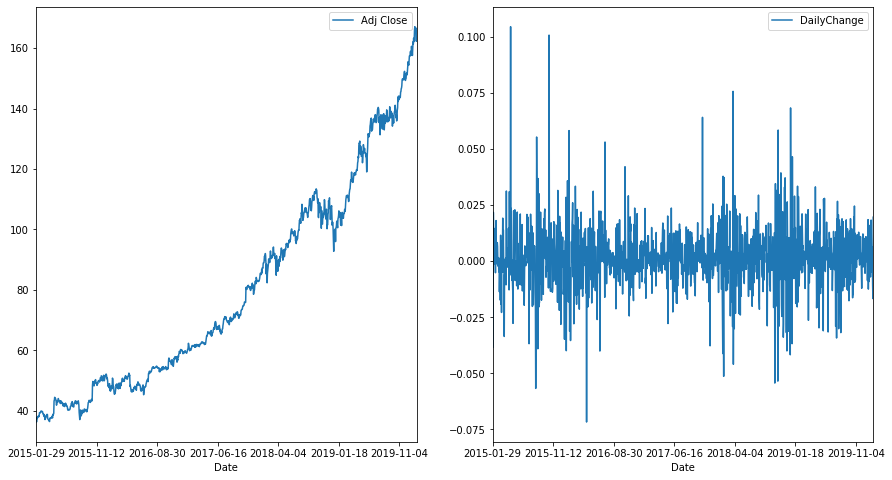

In [4]:
# Start by reading the data
df_historical = read_latest('msft', folder=DS_RAW)
#df_historical = pd.read_csv('../data/raw/msft_012920.csv', index_col='Date')

# Now calcualte the daily volatility
df_historical['DailyChange'] = df_historical['Adj Close'].pct_change()

fig, ax =plt.subplots(1,2,figsize=(15,8))
df_historical.plot(y='Adj Close', ax=ax[0])
df_historical.plot(y='DailyChange', ax=ax[1]);

# Simulated value using random daily volatility
Now what I want to do is simulate the value of a stock after 30 days, 60 days, 90 days, 180 days and at expiration
In order to do this, I'm going to run a simulation for the number of days which uses one of the historical days returns * the price
So simply 

day  open_price * random return = end_price

In [5]:
from src.stock_utils import getLikelyPrice
import datetime
import dateutil
# Get our starting price from the last close
starting_price = df_historical.iloc[-1]['Adj Close']
strike_price = 175.00 
option_date_text = '01/15/2021'
option_date = pd.to_datetime('01/15/2021') # Jan 15, 2021
call_price = 12.60
implied_volatility = 0.2333
zero_risk_rate = 0.017
days_til_expire = (option_date - pd.to_datetime(df_historical.index[-1]) ).days
option_cost = BlackSholes(starting_price,strike_price,implied_volatility,zero_risk_rate,option_date_text)
call_cost = option_cost[0]
put_cost = option_cost[1]

print(f'The calculated cost of the CALL for {option_date_text} with implied vol of {implied_volatility} '
      f'is {call_cost:.2f}')

print(f'The calculated cost of the PUT for {option_date_text} with implied vol of {implied_volatility} '
      f'is {put_cost:.2f}')

The calculated cost of the CALL for 01/15/2021 with implied vol of 0.2333 is 12.25
The calculated cost of the PUT for 01/15/2021 with implied vol of 0.2333 is 18.96


# Calculate the number of days we make money
Here we have to plug in various values of volatility to calculate the Black-Sholes value of the call option
Likely the solution here is to pick a volatility, get a call price for a particular date, 
then using Monte Carlo see how often we would make money by taking it all the way to expiration, 
by selling it in 30 days, 60 days, 90 days etc.

In [6]:
num_sims = 100
days_30 = [getLikelyPrice(starting_price, df_historical.iloc[1:]['DailyChange'],30).mean() for i in range(num_sims)]
days_90 = [getLikelyPrice(starting_price, df_historical.iloc[1:]['DailyChange'],90).mean() for i in range(num_sims)]
days_180 = [getLikelyPrice(starting_price, df_historical.iloc[1:]['DailyChange'],180).mean() for i in range(num_sims)]
days_all = [getLikelyPrice(starting_price, df_historical.iloc[1:]['DailyChange'],days_til_expire).mean() for i in range(num_sims)]

df_returns = pd.DataFrame({'30_days':days_30, '90_days':days_90, '180_days':days_180,'To_Expiration':days_all})

In [1]:
print(f'Executing {num_sims} the average price in 30 days is {df_returns["30_days"].mean():.2f}')
print(f'Executing {num_sims} the average price in 60 days is {df_returns["90_days"].mean():.2f}')
print(f'Executing {num_sims} the average price in 90 days is {df_returns["180_days"].mean():.2f}')
print(f'Executing {num_sims} the average price, holding til expiration is {df_returns["To_Expiration"].mean():.2f}')

df_returns['ITM_30'] = df_returns['30_days']-call_price-strike_price > 0
df_returns['ITM_90'] = df_returns['90_days']-call_price-strike_price > 0
df_returns['ITM_180'] = df_returns['180_days']-call_price-strike_price > 0
df_returns['ITM_All'] = df_returns['To_Expiration']-call_price-strike_price > 0 

print(f'ITM 30: {(df_returns["ITM_30"].sum()/num_sims)*100:.2f}% of the time')
print(f'ITM 90: {(df_returns["ITM_90"].sum()/num_sims)*100:.2f}% of the time')
print(f'ITM 180: {(df_returns["ITM_180"].sum()/num_sims)*100:.2f}% of the time')
print(f'ITM ALL: {(df_returns["ITM_All"].sum()/num_sims)*100:.2f}% of the time')

NameError: name 'num_sims' is not defined